# Baseline - XGBoost
starting with 5 yrs 2013-2017

In [1]:
import pandas as pd
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate, train_test_split
import glob

In [2]:
data_drive = r'F:/'

## 1. Assemble Data into a csv

In [3]:
stammdaten = pd.read_excel(data_drive +r'GruV-Net/data/Stammdaten_HE.xlsx')
stammdaten.set_index('Proj_ID', inplace=True)
gw_weekly = pd.read_csv(data_drive +r'GruV-Net/data/groundwater_levels_preprocessed_hesse/weekly/gw_lvl_complete.csv')
gw_weekly.set_index('Datum', inplace=True)

In [4]:
rws_folder = data_drive + r'GruV-Net/data/precipitation/weekly-sum/GTiff/'
temp_folder = data_drive + r'GruV-Net/data/temperature/GTiff/'

rws_files_paths = glob.glob(rws_folder+'*2008*.tif') + glob.glob(rws_folder+'*2009*.tif') + glob.glob(rws_folder+'*2010*.tif') + glob.glob(rws_folder+'*2011*.tif') + glob.glob(rws_folder+'*2012*.tif') +glob.glob(rws_folder+'*2013*.tif') + glob.glob(rws_folder+'*2014*.tif') + glob.glob(rws_folder+'*2015*.tif') + glob.glob(rws_folder+'*2016*.tif') + glob.glob(rws_folder+'*2017*.tif')
rws_files_paths.sort()
rws_files = list(map(os.path.basename, rws_files_paths))

In [5]:
def assemble_instances(files, file_paths, temp_path):
    data = []
    instances_list = []

    s = 'HE_10025'

    for i in range(0, len(files)-11):
        regnie_srcs =  []
        temp_srcs = []
        for l in range(0,12):
            regnie_srcs.append(rio.open(file_paths[i+l]))
        for l in (2, 6, 10):
            #Monatsauswahl noch tricky
            temp_srcs.append(rio.open(temp_path+'TAMM_'+ files[i+l][9:11]+'_'+files[i+l][4:8]+'_01.tif'))
        stations = gw_weekly.loc[ files[i][4:14] , : ].dropna().index.tolist()
        
        d = np.array([])
        instance_desc = []
        instance_desc.append(s)
        east = stammdaten.loc[s]['OSTWERT']
        north = stammdaten.loc[s]['NORDWERT']
        row, col = regnie_srcs[0].index(east, north)
        try:
            for src in regnie_srcs:
                r = src.read(1, window=rio.windows.Window(col-5, row-5, 11, 11)).flatten()
                if r.shape[0] != 121:
                    raise Exception
                else:
                    d = np.append(d, r)
                    instance_desc.append(src.name[48:-4])
        except Exception:
            continue
        try:
            for src in temp_srcs:
                r = src.read(1, window=rio.windows.Window(col-5, row-5, 11, 11)).flatten()
                if r.shape[0] != 121:
                    raise Exception
                else:
                    d = np.append(d, r)
                    instance_desc.append(src.name[35:-4])
        except Exception:
            continue
        try:    
            for k in [0, 4, 8]:
                #lieber in Prozent?
                change =  gw_weekly.loc[files[i+k+4][4:14], : ][s] - gw_weekly.loc[files[i+k][4:14], : ][s]
                if np.isnan(change):
                    raise Exception()
                else:
                    d = np.append(d, change)
                    instance_desc.append(files[i+k+4][4:14])
                    instance_desc.append(change)
        except Exception:
            continue 

        data.append(d)
        instances_list.append(instance_desc)
    return np.array(data), instances_list

In [6]:
instances, instances_list = assemble_instances(rws_files, rws_files_paths, temp_folder)

In [7]:
instances_list = pd.DataFrame(instances_list)

In [8]:
instances.shape

(299, 1818)

In [9]:
instances_list

0               1               2               3               4   \
0    HE_10025  rws_2008-01-14  rws_2008-01-21  rws_2008-01-28  rws_2008-02-04   
1    HE_10025  rws_2008-01-21  rws_2008-01-28  rws_2008-02-04  rws_2008-02-11   
2    HE_10025  rws_2008-02-18  rws_2008-02-25  rws_2008-03-03  rws_2008-03-10   
3    HE_10025  rws_2008-02-25  rws_2008-03-03  rws_2008-03-10  rws_2008-03-17   
4    HE_10025  rws_2008-03-17  rws_2008-03-24  rws_2008-03-31  rws_2008-04-07   
..        ...             ...             ...             ...             ...   
294  HE_10025  rws_2017-07-24  rws_2017-07-31  rws_2017-08-07  rws_2017-08-14   
295  HE_10025  rws_2017-08-14  rws_2017-08-21  rws_2017-08-28  rws_2017-09-04   
296  HE_10025  rws_2017-08-21  rws_2017-08-28  rws_2017-09-04  rws_2017-09-11   
297  HE_10025  rws_2017-09-11  rws_2017-09-18  rws_2017-09-25  rws_2017-10-02   
298  HE_10025  rws_2017-09-18  rws_2017-09-25  rws_2017-10-02  rws_2017-10-09   

                 5               6               7               8   \
0    rws_2008-02-11  rws_2008-02-18  rws_2008-02-25  rws_2008-03-03   
1    rws_2008-02-18  rws_2008-02-25  rws_2008-03-03  rws_2008-03-10   
2    rws_2008-03-17  rws_2008-03-24  rws_2008-03-31  rws_2008-04-07   
3    rws_2008-03-24  rws_2008-03-31  rws_2008-04-07  rws_2008-04-14   
4    rws_2008-04-14  rws_2008-04-21  rws_2008-04-28  rws_2008-05-05   
..              ...             ...             ...             ...   
294  rws_2017-08-21  rws_2017-08-28  rws_2017-09-04  rws_2017-09-11   
295  rws_2017-09-11  rws_2017-09-18  rws_2017-09-25  rws_2017-10-02   
296  rws_2017-09-18  rws_2017-09-25  rws_2017-10-02  rws_2017-10-09   
297  rws_2017-10-09  rws_2017-10-16  rws_2017-10-23  rws_2017-10-30   
298  rws_2017-10-16  rws_2017-10-23  rws_2017-10-30  rws_2017-11-06   

                 9   ...              12               13               14  \
0    rws_2008-03-10  ...  rws_2008-03-31  TAMM_01_2008_01  TAMM_02_2008_01   
1    rws_2008-03-17  ...  rws_2008-04-07  TAMM_02_2008_01  TAMM_03_2008_01   
2    rws_2008-04-14  ...  rws_2008-05-05  TAMM_03_2008_01  TAMM_03_2008_01   
3    rws_2008-04-21  ...  rws_2008-05-12  TAMM_03_2008_01  TAMM_04_2008_01   
4    rws_2008-05-12  ...  rws_2008-06-02  TAMM_03_2008_01  TAMM_04_2008_01   
..              ...  ...             ...              ...              ...   
294  rws_2017-09-18  ...  rws_2017-10-09  TAMM_08_2017_01  TAMM_09_2017_01   
295  rws_2017-10-09  ...  rws_2017-10-30  TAMM_08_2017_01  TAMM_09_2017_01   
296  rws_2017-10-16  ...  rws_2017-11-06  TAMM_09_2017_01  TAMM_10_2017_01   
297  rws_2017-11-06  ...  rws_2017-11-27  TAMM_09_2017_01  TAMM_10_2017_01   
298  rws_2017-11-13  ...  rws_2017-12-04  TAMM_10_2017_01  TAMM_10_2017_01   

                  15          16    17          18        19          20  \
0    TAMM_03_2008_01  2008-02-11 -0.03  2008-03-10  0.075000  2008-04-07   
1    TAMM_03_2008_01  2008-02-18  0.00  2008-03-17  0.160000  2008-04-14   
2    TAMM_04_2008_01  2008-03-17  0.16  2008-04-14  0.050000  2008-05-12   
3    TAMM_05_2008_01  2008-03-24 -0.02  2008-04-21  0.030000  2008-05-19   
4    TAMM_05_2008_01  2008-04-14  0.05  2008-05-12 -0.160000  2008-06-09   
..               ...         ...   ...         ...       ...         ...   
294  TAMM_10_2017_01  2017-08-21  0.00  2017-09-18  0.020000  2017-10-16   
295  TAMM_10_2017_01  2017-09-11 -0.01  2017-10-09 -0.020000  2017-11-06   
296  TAMM_10_2017_01  2017-09-18  0.02  2017-10-16 -0.020000  2017-11-13   
297  TAMM_11_2017_01  2017-10-09 -0.02  2017-11-06  0.036667  2017-12-04   
298  TAMM_11_2017_01  2017-10-16 -0.02  2017-11-13  0.050000  2017-12-11   

           21  
0    0.015000  
1    0.050000  
2   -0.160000  
3   -0.170000  
4   -0.065000  
..        ...  
294 -0.020000  
295  0.036667  
296  0.050000  
297 -0.076667  
298  0.130000  

[299 rows x 22 columns]

## 2. XGBoost model
### 2.1 with flattened raster

In [10]:
data = instances

In [11]:
data

array([[ 1.15463982e+01,  1.14382524e+01,  1.10546522e+01, ...,
        -3.00000000e-02,  7.50000000e-02,  1.50000000e-02],
       [ 2.38428354e+00,  2.34454536e+00,  2.28223586e+00, ...,
         0.00000000e+00,  1.60000000e-01,  5.00000000e-02],
       [ 3.83970833e+00,  3.83235884e+00,  3.84059453e+00, ...,
         1.60000000e-01,  5.00000000e-02, -1.60000000e-01],
       ...,
       [ 8.32609272e+00,  8.02999496e+00,  7.95865250e+00, ...,
         2.00000000e-02, -2.00000000e-02,  5.00000000e-02],
       [ 5.23279533e+01,  5.24378014e+01,  5.13220940e+01, ...,
        -2.00000000e-02,  3.66666667e-02, -7.66666667e-02],
       [ 2.89500499e+00,  2.97251654e+00,  2.93766904e+00, ...,
        -2.00000000e-02,  5.00000000e-02,  1.30000000e-01]])

In [12]:
X = data[:,:-1]
Y = data[:,-1]

In [13]:
print(X.shape)
print(Y.shape)

(299, 1817)
(299,)


In [14]:
cv = TimeSeriesSplit(5)

In [15]:
model = xgb.XGBRegressor(objective ='reg:squarederror')
results = cross_validate(model, X, Y, cv=cv, scoring='neg_root_mean_squared_error')

In [16]:
for i in range(5):
    print('RMSE split '+str(i+1)+': '+ str(np.negative(results['test_score'][i])))

RMSE split 1: 0.0723348502736659
RMSE split 2: 0.11521727921511657
RMSE split 3: 0.09059972966138467
RMSE split 4: 0.16087763495449622
RMSE split 5: 0.12513349460130588


### 2.2 Model analysis

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.1666, shuffle=False)

In [18]:
model.fit(X_train, y_train)

XGBRegressor(objective='reg:squarederror')

In [19]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))

RMSE: 0.119194
MAE: 0.088490


In [20]:
importances = model.feature_importances_

<BarContainer object of 1817 artists>

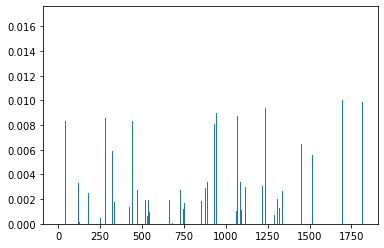

In [21]:
plt.bar(range(len(importances)), importances)

In [22]:
importances.max()

0.016791396

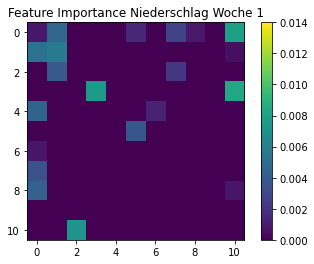

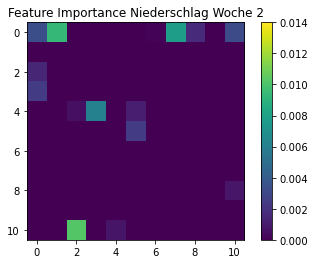

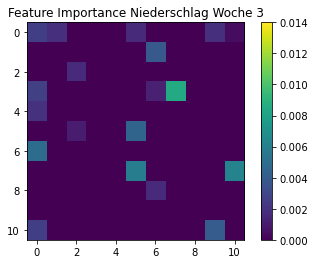

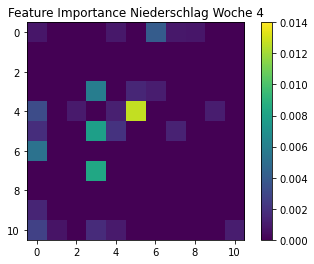

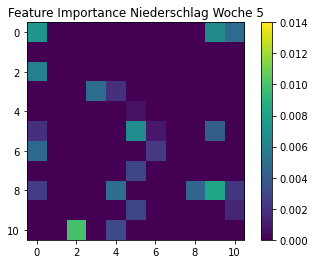

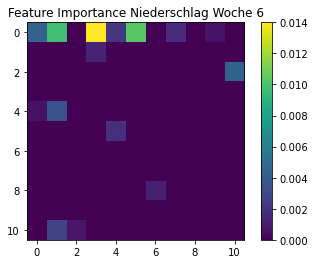

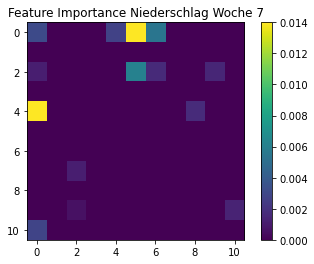

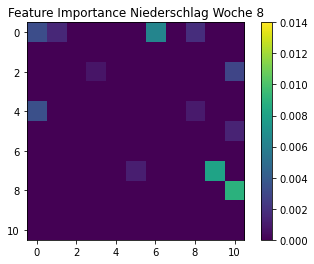

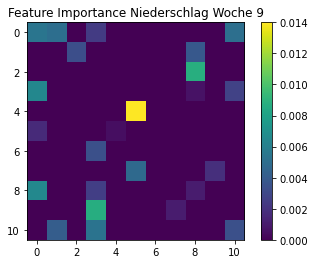

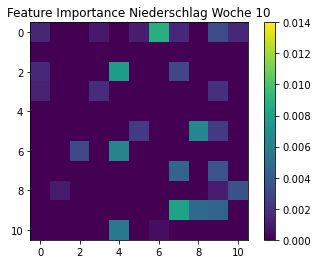

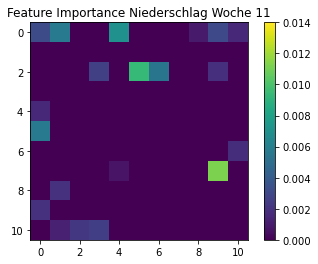

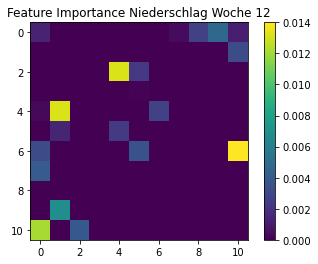

In [23]:
for i in range(12):
    plt.title('Feature Importance Niederschlag Woche '+str(i+1))
    plt.imshow(importances[i*121:(i+1)*121].reshape((11,11)), vmin=0, vmax=0.014)
    plt.colorbar()
    plt.show()

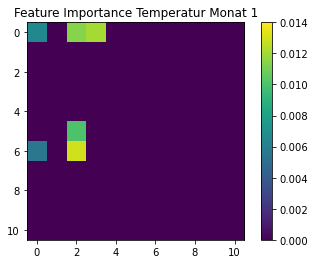

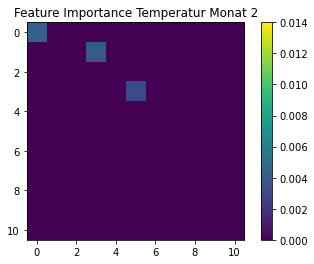

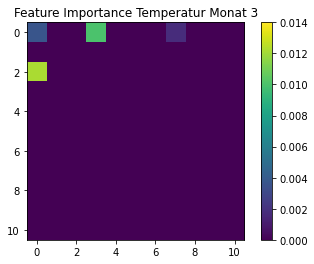

In [24]:
for i in range(3):
    plt.title('Feature Importance Temperatur Monat '+str(i+1))
    plt.imshow(importances[(i+12)*121:(i+13)*121].reshape((11,11)), vmin=0, vmax=0.014)
    plt.colorbar()
    plt.show()

In [25]:
print('Feature Importance Messtand 4 Wochen vor letzem Messtand: '+ str(importances[1815]))
print('Feature Importance letzer Messtand: '+ str(importances[1816]))

Feature Importance Messtand 4 Wochen vor letzem Messtand: 0.0032040244
Feature Importance letzer Messtand: 0.009854756


## 3. Evaluation

In [26]:
ae = np.abs(preds - y_test)

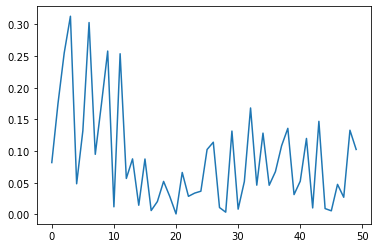

In [27]:
plt.plot(ae)

In [28]:
worst_instances = (-ae).argsort()[:20]
worst_instances

array([ 3,  6,  9,  2, 11,  1,  8, 32, 43, 38, 48,  5, 29, 34, 41, 26, 37,
       49, 25,  7], dtype=int64)